In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/lec/git/pyfpm')
import matplotlib.pyplot as plt
from IPython.display import SVG, display
import numpy as np

import pyfpm.fpmmath as fpm

## Deconvolucion usando condiciones reflexivas

Implementación de deconvolución usando regularización de Tikhonov para el caso de condiciones de borde reflexivas, para las cuales la reconstrucción puede hacerse eficientemente usando la transformada coseno. Para más información leer el capítulo 4 de "Deblurring Images - Matrices, Spectra, and Filtering", P. C. Hansen, J. G. Nagy, and D. P. O'Leary, SIAM, Philadelphia, 2006.

Primero evalúo los algoritmos para el caso de una pupila cuadrada. Como ocurre para los problemas 'ill possed', añadir una mínima cantidad de ruido hace que la solución naif (i.e min(|Ax-b|^2)) diverja en frecuencias altas. Para est ose implementó alternativamente un algoritmo basado en la periodicidad reflexiva de la PSF (o de la imagen original, pero se traduce en que la matriz A se puede descomponer usando transformadas coseno) usando regularización segń Tikhonov (i.e min(|Ax-b|^2-alpha*|x|^2)).

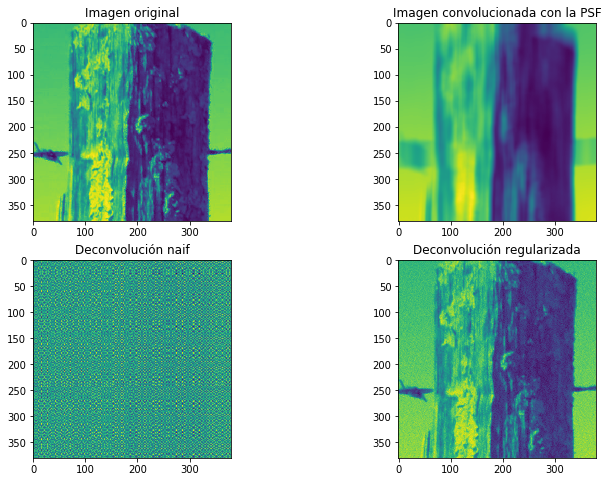

In [112]:
from scipy import fftpack, ndimage
import pyfpm.deconvolution as dc
## El objeto muestreado
# X = ndimage.imread('cameraman.tif', flatten=True)
X = ndimage.imread('alambre.png', flatten=True) 
X = X[0:380, 0:380]
PSF = np.zeros_like(X)
PSF[110:215, 160:195] = 1
B = dc.blured_image(PSF=PSF, X=X)
Bn = B+10*np.random.randn(np.shape(B)[0], np.shape(B)[1])
naive = np.real(dc.naive_deconv(PSF, Bn))
tik, alpha = dc.tik_dct(PSF, Bn, alpha=.5)

fig, axes = plt.subplots(2, 2, figsize = [12 ,8])
axes[0][0].imshow(X)
axes[0][0].set_title('Imagen original')
axes[0][1].imshow(np.real(Bn))
axes[0][1].set_title('Imagen convolucionada con la PSF')
axes[1][0].imshow(naive)
axes[1][0].set_title('Deconvolución naif')
axes[1][1].imshow(np.real(tik))
axes[1][1].set_title('Deconvolución regularizada')
plt.show()

Hago el mismo test para una PSF compleja, tomada a partir de la transformada de una pupila circular corrida en el espacio de frecuencias. Acá es mñas patente el efecto del ruido, estimo que por el hecho de que las componentes de la imagen formante son de bastante menor intensidad.

[190, 190]


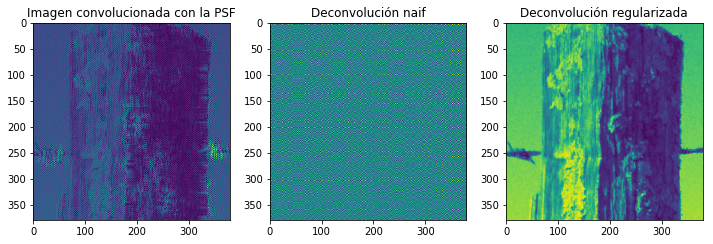

In [29]:
NPX, NPY = np.shape(X)
f0 = [120, 100]
def psf_wrap(f):
    fx, fy = f
    pupil_radius = 10
    pupil = fpm.generate_pupil(fx=fx, fy=fy, image_size=[NPY, NPX],
                               pupil_radius=pupil_radius)
    PSF = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(pupil)))
    return PSF

B = dc.blured_image(PSF=psf_wrap(f0), X=X)
Bn = B+1.5E3*np.random.randn(np.shape(B)[0], np.shape(B)[1])
naive = dc.naive_deconv(PSF, Bn)
tik0, alpha = dc.tik_dct(PSF=psf_wrap(f0), B=Bn, alpha=5)

fig, axes = plt.subplots(1, 3, figsize = [12 ,8])
axes[0].imshow(np.abs(Bn))
axes[0].set_title('Imagen convolucionada con la PSF')
axes[1].imshow(np.real(naive))
axes[1].set_title('Deconvolución naif')
axes[2].imshow(np.real(tik0))
axes[2].set_title('Deconvolución regularizada')
plt.show()

Tomando la reconstrucción anterior evalúo el costo de reconstruir la imagen con una PSF mal especificada. Como medida de la validez de la reconstrucción uso Generalized Cross Validation.

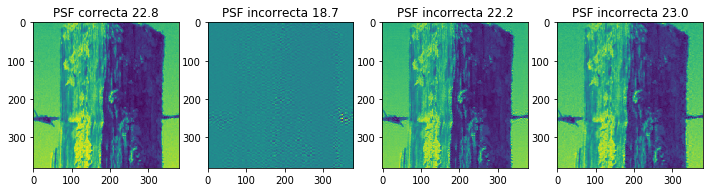

In [30]:
f = [[120, 100], [90, 50], [120, 130], [100, 100]]
alpha = .1
tik0, G0 = dc.tik_dct(PSF=psf_wrap(f[0]), B=Bn, alpha=alpha, cg=True)
tik1, G1 = dc.tik_dct(PSF=psf_wrap(f[1]), B=Bn, alpha=alpha, cg=True)
tik2, G2 = dc.tik_dct(PSF=psf_wrap(f[2]), B=Bn, alpha=alpha, cg=True)
tik3, G3 = dc.tik_dct(PSF=psf_wrap(f[3]), B=Bn, alpha=alpha, cg=True)

fig, axes = plt.subplots(1, 4, figsize = [12 ,8])
axes[0].imshow(np.real(tik0))
axes[0].set_title('PSF correcta %.1f' % np.log(G0))
axes[1].imshow(np.real(tik1))
axes[1].set_title('PSF incorrecta %.1f' % np.log(G1))
axes[2].imshow(np.real(tik2))
axes[2].set_title('PSF incorrecta %.1f' % np.log(G2))
axes[3].imshow(np.real(tik3))
axes[3].set_title('PSF incorrecta %.1f' % np.log(G3))
plt.show()

Para la solución de Tikhonov, la norma de la solución es una función monotónicamente no creciente de alpha, mientras que el residuo es monotónicamente no creciente.

El próximo paso es ver como implementar esto con imágenes que son salida de |Ax|^2, para lo cual no tengo (en principio) una forma cerrada para la matriz de convolución equivalente. 

## Aplico la solución para DPC

Genero las imágenes de prueba e DPC, que consisnten en dos semicírculos antisimétricos y la aplico a una imagen con magnitud y fase de prueba. Uso las clases derivadas de MatrixShape, que implementan el cálculo de PSF y complementos de pupilas asimetricas.

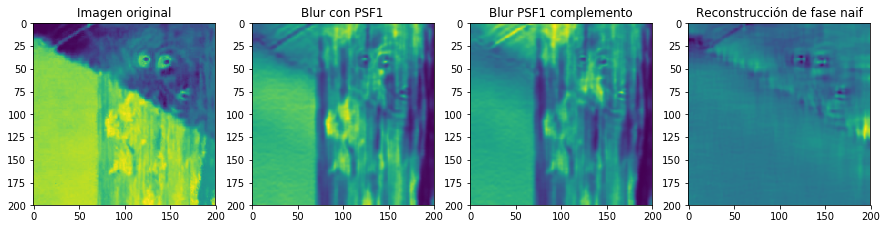

In [194]:
from scipy import misc, signal

# Cargo la imagen de prueba con modulo y fase arbitrarios
npx = 200
radius = 60
mag_array = misc.imread('../sandbox/alambre.png', 'F')[:npx, :npx]
image_phase = misc.imread('../sandbox/lines0_0.png', 'F')[:npx,:npx]
ph_array = np.pi*(image_phase)/np.amax(image_phase)
image_array = mag_array*np.exp(1j*ph_array)

# Construyo las pupilas relevantes
sc_up = fpm.SemiCircle(dim=npx, radius=radius, angle=0)
dpc_psf = sc.psf-sc.complementary_psf()

# Aplico la convolución dada por las PSFs de las pupilas asimétricas
blurred_up = np.abs(dc.blured_image(PSF=sc.psf, X=image_array))**2
blurred_down = np.abs(dc.blured_image(PSF=sc.complementary_psf(), X=image_array))**2


# # La reconstrucción naif viene dado por sumas y restas de las imagenes con pupilas asimetricas
dpc_naive = dc.get_dpc(image_array, angle=0, npx=npx, radius=radius)


# Grafico ambas imágenes y la parte imaginaria de la solución obtenida restando ambas imagenes asimétricas
fig, axes = plt.subplots(1, 4, figsize = [15 ,8])
axes[0].imshow(np.real(image_array)), axes[0].set_title('Imagen original')
axes[1].imshow(np.real(blurred_up)), axes[1].set_title('Blur con PSF1')
axes[2].imshow(np.real(blurred_down)), axes[2].set_title('Blur PSF1 complemento')
axes[3].imshow(np.real(dpc_naive)), axes[3].set_title('Reconstrucción de fase naif')
plt.show()

Las mismas reconstrucciones añadiendo el algoritmo de deconvolución regularizada.

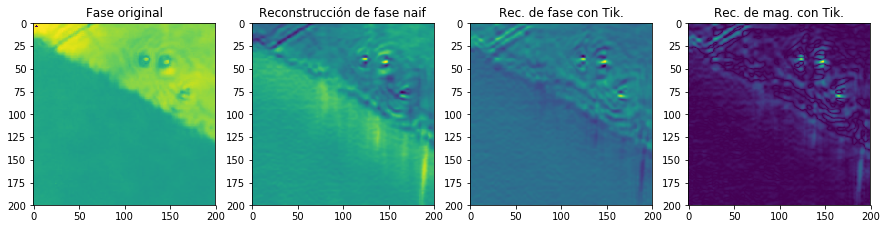

In [188]:
tik1, G1 = dc.tik_dct(PSF=dpc_psf, B=dpc_naive, alpha=5, cg=True)
 
fig, axes = plt.subplots(1, 4, figsize = [15 ,8])
axes[0].imshow(np.angle(image_array)), axes[0].set_title('Fase original')
axes[1].imshow(np.real(dpc_naive)), axes[1].set_title('Reconstrucción de fase naif')
axes[2].imshow(np.imag(tik1)), axes[2].set_title('Rec. de fase con Tik.')
axes[3].imshow(np.abs(tik1)), axes[3].set_title('Rec. de mag. con Tik.')
plt.show()

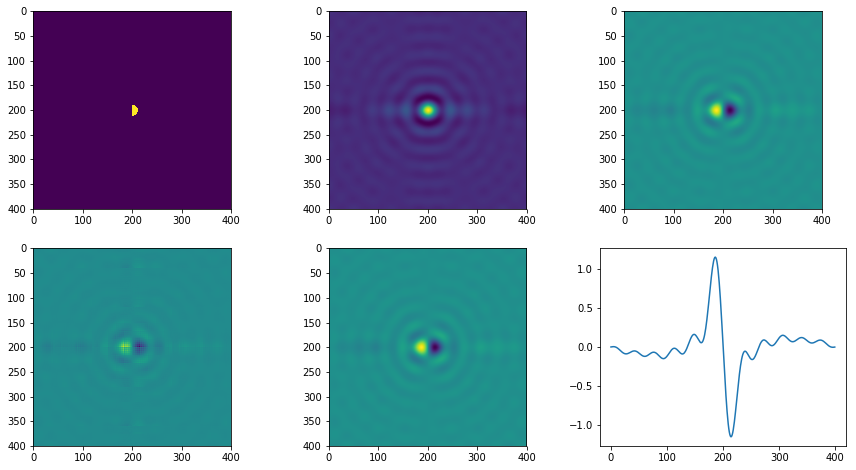

In [109]:
sc = fpm.SemiCircle(dim=400, radius=12, angle=90)
fig, axes = plt.subplots(2, 3, figsize = [15, 8])
axes[0][0].imshow(sc.matrix)
axes[0][1].imshow(sc.psf_real())
axes[0][2].imshow(sc.psf_imag())
psf = sc.psf-sc.complementary_psf()
axes[1][0].imshow(np.real(psf))
axes[1][1].imshow(np.imag(psf))
axes[1][2].plot(np.imag(psf[200,:]))

plt.show()

## Bibliografía

"Deblurring Images - Matrices, Spectra, and Filtering", P. C. Hansen, J. G. Nagy, and D. P. O'Leary, SIAM, Philadelphia, 2006.
http://kmdouglass.github.io/posts/simple-pupil-function-calculations.html